## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error, mean_absolute_error
from matplotlib import ticker
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima

In [2]:
df = pd.read_csv("ABBV-AbbVie.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,79.769997,80.849998,79.279999,80.099998,62.999916,8567900
1,2019-03-04,80.400002,80.730003,79.110001,79.459999,62.496544,5872500
2,2019-03-05,79.379997,79.900002,78.720001,78.910004,62.063961,5933100
3,2019-03-06,79.129997,79.129997,77.559998,78.089996,61.419022,5293200
4,2019-03-07,77.769997,79.120003,77.440002,78.239998,61.537010,6642500
...,...,...,...,...,...,...,...
1318,2024-05-24,158.360001,158.779999,156.360001,157.059998,157.059998,3689900
1319,2024-05-28,156.350006,156.350006,153.949997,155.339996,155.339996,5533500
1320,2024-05-29,154.889999,156.380005,153.679993,154.789993,154.789993,4254500
1321,2024-05-30,154.649994,156.429993,153.580002,156.309998,156.309998,4311100


## Reset index

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [4]:
# Select the Close column as the dependent variable
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

## Data normalization

In [5]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

## Data splitting

In [6]:
# Split the data into training, validation and test dataset in a ratio of 6:4
train_size = int(0.6 * len(data_scaled))
test_size = len(data_scaled) - train_size

train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

## Model training and testing

## Training process

In [7]:
# Preparing training data
x_train = np.arange(train_size).reshape(-1, 1)
y_train = train_data.reshape(-1)

In [8]:
# Find the best ARIMA model using auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4556.175, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4559.684, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4558.684, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4558.568, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4558.717, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4557.505, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.441 seconds


In [9]:
# Fit the model
model.fit(y_train)

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

## Testing Processing

In [10]:
x_test = np.array(range(train_size, len(data_scaled))).reshape(-1, 1)
y_test = np.array(test_data).reshape(-1)
y_pred = model.predict(n_periods=len(y_test))

## Evaluate Model

In [11]:
# Evaluate the accuracy of test
y_test = scaler.inverse_transform(np.array([y_test]).reshape(-1, 1))
y_pred = scaler.inverse_transform(np.array([y_pred]).reshape(-1, 1))

test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_msle = mean_squared_log_error(y_test, y_pred)

print(f"MAPE on Test dataset: ", test_mape)
print(f"RMSE on Test dataset: ", test_rmse)
print(f"MSLE on Test dataset: ", test_msle)
print(f"MAE on Test dataset: ", test_mae)

MAPE on Test dataset:  0.21605473574002335
RMSE on Test dataset:  35.39463016347889
MSLE on Test dataset:  0.04335210457511299
MAE on Test dataset:  32.407604835387


# Predicting the next 30 days

## Preparing the prediction data

In [12]:
# The process of creating index predict next 30 days
last_index = df_Close.index[-1]

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index + 1, last_index + 31)).reshape(-1, 1)

## Prediction process

In [13]:
# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))
y_next_30_days = scaler.inverse_transform(np.array([y_next_30_days]).reshape(-1, 1))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days.flatten())

Predicted closing prices for the next 30 days:
[158.61901703 158.71803006 158.81704309 158.91605612 159.01506914
 159.11408217 159.2130952  159.31210823 159.41112126 159.51013429
 159.60914732 159.70816035 159.80717338 159.9061864  160.00519943
 160.10421246 160.20322549 160.30223852 160.40125155 160.50026458
 160.59927761 160.69829064 160.79730367 160.89631669 160.99532972
 161.09434275 161.19335578 161.29236881 161.39138184 161.49039487]


## Preparing the forecast date index

In [14]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

## Visualization

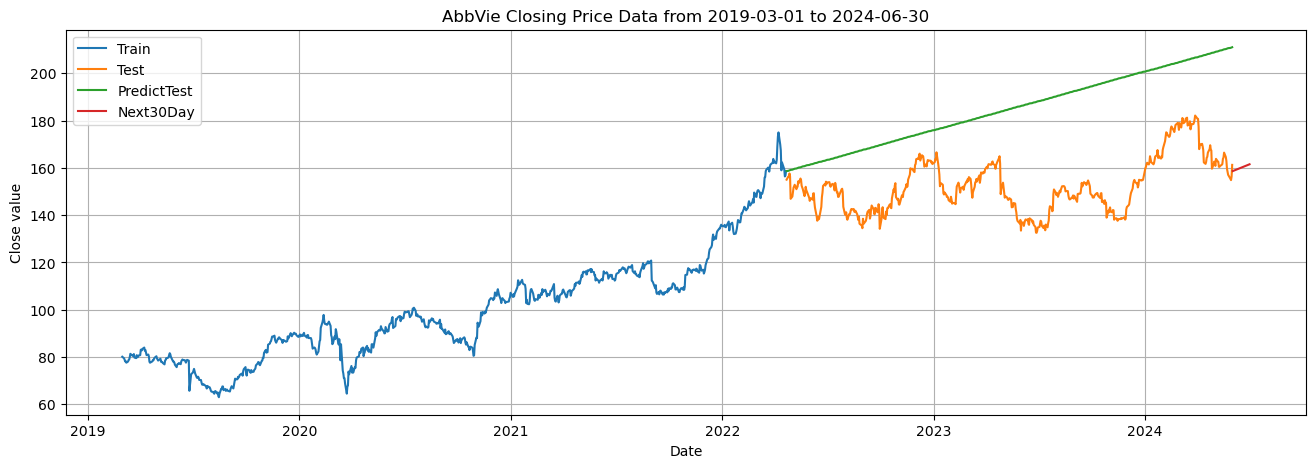

In [15]:
# Drawing
plt.figure(figsize=(16, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(np.array([y_train]).reshape(-1, 1)))
plt.plot(df.index[train_size:], y_test)
plt.plot(df.index[train_size:], y_pred)
plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Test', 'PredictTest', 'Next30Day'])
plt.grid()
plt.title(f"AbbVie Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('image/ARIMA_64_30day_ABBV.png')
plt.show()